In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from uuid import UUID

import matplotlib.pyplot as plt

import sys
sys.path.append('/Users/mallen2/alternate_branches/gis-with-build-label-model/e-mission-server')

import confusion_matrix_handling as cm_handling

In [2]:
### Run a simulation to see whether the trip level variance propagation method is systematically biased by number of predictions in each category.
# Assume 4 trips, with each being 10 miles. 
# If by chance they actually were car ebike ebike ebike, but we predicted car car car ebike, does our variance account for that?
    # it seems like it does if you group together the distances in each mode first. 

EI_values = np.array([1.5,0.022]) # car, ebike
p_mode_given_predict_car = np.array([0.8, 0.2])
p_mode_given_predict_ebike = np.array([0.2,0.8]) 

car_expected_EI = cm_handling.expectation(p_mode_given_predict_car,EI_values)
car_E2 = cm_handling.expectation(p_mode_given_predict_car,EI_values**2)
V_car = car_E2 - car_expected_EI**2
print(V_car)

ebike_expected_EI = cm_handling.expectation(p_mode_given_predict_ebike,EI_values)
ebike_E2 = cm_handling.expectation(p_mode_given_predict_ebike,EI_values**2)
V_ebike = ebike_E2 - ebike_expected_EI**2
print(f"v_ebike = {V_ebike}")

actual_EC_total = 10*(EI_values[0] + 3* EI_values[1])  # 1 car, 3 ebikes
expected_EC_total = 10*(3*car_expected_EI + ebike_expected_EI) # predict 3 car, 1 ebike

EC_total_var = 30**2*V_car + 10**2*V_ebike
agg_sd = np.sqrt(EC_total_var)

print(actual_EC_total,expected_EC_total,(expected_EC_total - actual_EC_total)/agg_sd)

0.3495174399999996
v_ebike = 0.34951743999999996
15.66 39.30800000000001 1.2649110640673527


In [3]:
def trip_simulator(n_car, n_ebike, trip_distance):
    actual_trips = ['car']*n_car + ['ebike']*n_ebike

    # make predictions for car trips. 0 represents ebike, 1 represents car
    predictions_for_car_trips = np.random.choice([0,1],size=n_car, replace=True, p = [0.4,0.6])

    # make predictions for ebike trips
    predictions_for_ebike_trips = np.random.choice([0,1],size=n_ebike, replace=True, p = [0.6,0.4])

    # Calculate expected and actual energy consumptions, assuming 10 miles.
    actual_EC_total = trip_distance*(n_car*EI_values[0] + n_ebike*EI_values[1])

    n_car_predictions = sum(predictions_for_car_trips) + sum(predictions_for_ebike_trips)
    n_ebike_predictions = n_car + n_ebike - n_car_predictions

    predicted_EC_total = trip_distance*(n_car_predictions*EI_values[0] + n_ebike_predictions*EI_values[1])
    expected_EC_total = trip_distance*(n_car_predictions*car_expected_EI + n_ebike_predictions*ebike_expected_EI)

    car_distance = trip_distance*n_car_predictions
    ebike_distance = trip_distance*n_ebike_predictions

    # Variance if we use aggregate distances
    EC_total_var_using_aggregate_distances = car_distance**2*V_car + ebike_distance**2*V_ebike

    agg_distance_agg_sd = np.sqrt(EC_total_var_using_aggregate_distances)
    agg_distance_n_sd = (expected_EC_total - actual_EC_total)/agg_distance_agg_sd

    # If we use individual distances
    EC_total_var_using_individual_distances = n_car_predictions*(trip_distance**2*V_car) + n_ebike_predictions*(trip_distance**2*V_ebike)

    indiv_distance_agg_sd = np.sqrt(EC_total_var_using_individual_distances)
    indiv_distance_n_sd = (expected_EC_total - actual_EC_total)/indiv_distance_agg_sd

    # reliably a bad variance estimate with individual version!
    #print(f"actual EC: {actual_EC_total}, expected EC: {expected_EC_total:.1f}, predicted EC: {predicted_EC_total:.1f}")
    #print(f"\terror for expected: {expected_EC_total - actual_EC_total:.1f},\n\terror for predicted: {predicted_EC_total - actual_EC_total:.1f}")
    print(f"With aggregate distance:\n\tsd aggregate: {agg_distance_agg_sd:.1f}. Number of standard deviations from mean: {agg_distance_n_sd:.1f}")
    print(f"With individual distance:\n\tsd aggregate: {indiv_distance_agg_sd:.1f}. Number of standard deviations from mean: {indiv_distance_n_sd:.1f}")

# try it with predicted and try it with modeshare.
car_number_list = [30,40,50,60,70,80,90]


# which does better on average in each situation?

for n_car in car_number_list:
    print(f"{n_car} car trips, {100 - n_car} ebike trips")
    trip_simulator(n_car,100-n_car, 10)

30 car trips, 70 ebike trips
With aggregate distance:
	sd aggregate: 423.4. Number of standard deviations from mean: 0.5
With individual distance:
	sd aggregate: 59.1. Number of standard deviations from mean: 3.8
40 car trips, 60 ebike trips
With aggregate distance:
	sd aggregate: 423.4. Number of standard deviations from mean: 0.2
With individual distance:
	sd aggregate: 59.1. Number of standard deviations from mean: 1.3
50 car trips, 50 ebike trips
With aggregate distance:
	sd aggregate: 418.4. Number of standard deviations from mean: -0.0
With individual distance:
	sd aggregate: 59.1. Number of standard deviations from mean: -0.3
60 car trips, 40 ebike trips
With aggregate distance:
	sd aggregate: 420.1. Number of standard deviations from mean: -0.2
With individual distance:
	sd aggregate: 59.1. Number of standard deviations from mean: -1.7
70 car trips, 30 ebike trips
With aggregate distance:
	sd aggregate: 423.4. Number of standard deviations from mean: -0.5
With individual distan

In [4]:
def trip_set_simulator(n_car, n_ebike, trip_distance, NMC, p_sensed_given_actual_car = {"ebike": 0.4, "car": 0.6}, p_sensed_given_actual_ebike = {"ebike": 0.6, "car": 0.4}):
    '''
    Simulate aggregate EC calculations for 2 modes: car and ebike.
    Start with a set of actual modes, and then assign sensed modes based on probabilities that depend on the actual mode.
        For example, if the actual mode is car and p_sensed_given_actual_car = [0.4,0.6], 
        then there is a 40% chance that we will predict ebike and 60% chance of predicting car.

    By "binomial" I mean that the set of predictions in each class is assumed to come from a binomial distribution.

    Right now the question is, which performs better on average? Expected EC or predicted EC?
    '''

    #prior_mode_probs = {"car": n_car/(n_car + n_ebike), "ebike":  n_ebike/(n_car + n_ebike)}
    prior_mode_probs = {"car": 0.5, "ebike":  0.5}
    row_normalized_confusion_matrix = pd.DataFrame({"ebike": p_sensed_given_actual_ebike, "car": p_sensed_given_actual_car})
    likelihood_times_priors = row_normalized_confusion_matrix.multiply(pd.Series(prior_mode_probs), axis='rows')
    normalizing_constants = likelihood_times_priors.sum(axis='rows')
    prob_actual_given_predicted_df = likelihood_times_priors.divide(normalizing_constants, axis='columns').copy()

    # Compute EI expected values and variances
    # [ebike value, car value]
    EI_values = np.array([0.022,1.5]) 

    car_expected_EI = cm_handling.expectation(prob_actual_given_predicted_df["car"],EI_values)
    car_E2 = cm_handling.expectation(prob_actual_given_predicted_df["car"],EI_values**2)

    ebike_expected_EI = cm_handling.expectation(prob_actual_given_predicted_df["ebike"],EI_values)
    ebike_E2 = cm_handling.expectation(prob_actual_given_predicted_df["ebike"],EI_values**2)
    V_ebike = ebike_E2 - ebike_expected_EI**2

    predicted_EC_list = np.array([])
    expected_EC_list = np.array([])
    binomial_EC_list = np.array([])

    predicted_expected_avg_list = np.array([])
   
    # Calculate expected and actual energy consumptions, assuming 10 miles.
    actual_EC_total = trip_distance*(n_car*EI_values[0] + n_ebike*EI_values[1])
    #print(f"actual EC: {actual_EC_total}")

    for j in range(0,NMC):
        # make predictions for car trips. 0 represents ebike, 1 represents car
        predictions_for_car_trips = np.random.choice([0,1],size=n_car, replace=True, p = [p_sensed_given_actual_car['ebike'], p_sensed_given_actual_car['car']])

        # make predictions for ebike trips
        predictions_for_ebike_trips = np.random.choice([0,1],size=n_ebike, replace=True, p = [p_sensed_given_actual_ebike['ebike'], p_sensed_given_actual_ebike['car']])

        n_car_predictions = sum(predictions_for_car_trips) + sum(predictions_for_ebike_trips)
        n_ebike_predictions = n_car + n_ebike - n_car_predictions

        car_distance = trip_distance*n_car_predictions
        ebike_distance = trip_distance*n_ebike_predictions

        # 0 is ebike, 1 is car
        expected_distance_in_car = np.dot(prob_actual_given_predicted_df.loc["car"], np.array(ebike_distance,car_distance))#p_actual_given_predict_car[1]*car_distance + p_actual_given_predict_ebike[1]*ebike_distance
        expected_distance_in_ebike = np.dot(prob_actual_given_predicted_df.loc["ebike"], np.array(ebike_distance,car_distance))

        # Compute the estimates for the current iteration.
        predicted_EC = car_distance*EI_values[0] + ebike_distance*EI_values[1]
        expected_EC = car_distance*car_expected_EI + ebike_distance*ebike_expected_EI
        binomial_EC = expected_distance_in_car*EI_values[0] + expected_distance_in_ebike*EI_values[1]
        predicted_expected_avg_EC = np.mean([predicted_EC,expected_EC])

        # Append to their respective lists.
        predicted_EC_list = np.append(predicted_EC_list, predicted_EC)
        expected_EC_list = np.append(expected_EC_list, expected_EC)
        binomial_EC_list = np.append(binomial_EC_list, binomial_EC)
        predicted_expected_avg_list = np.append(predicted_expected_avg_list, predicted_expected_avg_EC)

    prediction_errors = predicted_EC_list - actual_EC_total
    expected_EC_errors = expected_EC_list - actual_EC_total
    binomial_EC_errors = binomial_EC_list - actual_EC_total
    predicted_expected_avg_errors = predicted_expected_avg_list - actual_EC_total

    prediction_var, expected_var, binomial_var, predicted_expected_var = np.var(predicted_EC_list), np.var(expected_EC_list), np.var(binomial_EC_list), np.var(predicted_expected_avg_list)

    print(f"\tMean error for predicted: {np.mean(prediction_errors):.1f}. Error quantiles (25,75): {np.quantile(prediction_errors, [0.25,0.75])}. var of predicted: {prediction_var:.1f}")
    print(f"\tMean error for expected: {np.mean(expected_EC_errors):.1f}. Error quantiles (25,75): {np.quantile(expected_EC_errors, [0.25,0.75])}. var of expected: {expected_var:.1f}")
    print(f"\tMean error for binomial: {np.mean(binomial_EC_errors):.1f}. Error quantiles (25,75): {np.quantile(binomial_EC_errors, [0.25,0.75])}. var of binomial: {binomial_var:.1f}")
    #print(f"\tMean error for average: {np.mean(predicted_expected_avg_errors):.1f}. Error quantiles (25,75): {np.quantile(predicted_expected_avg_errors, [0.25,0.75])}. var of combined estimate: {predicted_expected_var:.1f}")

# try it with predicted and try it with modeshare.
car_number_list = [30,40,50,60,70,80,90]


# which does better on average in each situation?

for n_car in car_number_list:
    print(f"{n_car} car trips, {100 - n_car} ebike trips")
    trip_set_simulator(n_car,100-n_car, 10, NMC = 5000)

30 car trips, 70 ebike trips
	Mean error for predicted: -237.4. Error quantiles (25,75): [-280.82 -192.14]. var of predicted: 5082.8
	Mean error for expected: -284.0. Error quantiles (25,75): [-292.644 -274.908]. var of expected: 203.3
	Mean error for binomial: -646.1. Error quantiles (25,75): [-725.472 -565.848]. var of binomial: 7753.7
40 car trips, 60 ebike trips
	Mean error for predicted: -118.6. Error quantiles (25,75): [-162.58  -73.9 ]. var of predicted: 5363.9
	Mean error for expected: -142.0. Error quantiles (25,75): [-150.756 -133.02 ]. var of expected: 214.6
	Mean error for binomial: -513.2. Error quantiles (25,75): [-589.936 -436.224]. var of binomial: 7377.6
50 car trips, 50 ebike trips
	Mean error for predicted: -1.6. Error quantiles (25,75): [-44.34  44.34]. var of predicted: 5341.3
	Mean error for expected: -0.3. Error quantiles (25,75): [-8.868  8.868]. var of expected: 213.7
	Mean error for binomial: -381.3. Error quantiles (25,75): [-454.4 -306.6]. var of binomial: 6

### A look at modeshare
**Note that as the true distribution of car vs ebike gets further from our prior mode distribution, 
our estimates for the counts get further from the truth. The distance in standard deviations also becomes larger.**
- if the prior probabilities are 50-50, then cases of 10-90 or 90-10 are where the estimate is worst.

In [5]:
# Note: in my simulation, the true chance of predicted mode given actual mode is the same as the value I use in my confusion matrix.
# This is not the case with real data - the mobilitynet confusion matrix approximates the true chances of predicted given actual.

def trip_set_simulator_mode_counts(n_car, n_ebike, trip_distance, NMC, prior_mode_probs,
                                p_sensed_given_actual_car, 
                                p_sensed_given_actual_ebike
                                ):
    '''
    Simulate mode count calculations for 2 modes: car and ebike.
    Start with a set of actual modes, and then assign sensed modes based on probabilities that depend on the actual mode.
        For example, if the actual mode is car and p_sensed_given_actual_car = [0.4,0.6], 
        then there is a 40% chance that we will predict ebike and 60% chance of predicting car.

    By "binomial" I mean that the set of predictions in each class is assumed to come from a binomial distribution.
    '''

    #prior_mode_probs = {"car": n_car/(n_car + n_ebike), "ebike":  n_ebike/(n_car + n_ebike)}
    row_normalized_confusion_matrix = pd.DataFrame({"ebike": p_sensed_given_actual_ebike, 
                                                    "car": p_sensed_given_actual_car})
    #print(row_normalized_confusion_matrix)
    likelihood_times_priors = row_normalized_confusion_matrix.multiply(pd.Series(prior_mode_probs), axis='rows')
    normalizing_constants = likelihood_times_priors.sum(axis='rows')
    prob_actual_given_predicted_df = likelihood_times_priors.divide(normalizing_constants, axis='columns').copy()
    #print(prob_actual_given_predicted_df)

    #predicted_count_list = np.array([])
    #expected_EC_list = np.array([])

    # make predictions for car trips. 0 represents ebike, 1 represents car
    predictions_for_car_trips = np.random.choice([0,1],size=n_car, replace=True, p = [p_sensed_given_actual_car['ebike'], p_sensed_given_actual_car['car']])

    # make predictions for ebike trips
    predictions_for_ebike_trips = np.random.choice([0,1],size=n_ebike, replace=True, p = [p_sensed_given_actual_ebike['ebike'], p_sensed_given_actual_ebike['car']])

    n_car_predictions = sum(predictions_for_car_trips) + sum(predictions_for_ebike_trips)
    n_ebike_predictions = n_car + n_ebike - n_car_predictions

    # 0 is ebike, 1 is car
    
    # Find the expected counts of each mode.
    expected_car_count = prob_actual_given_predicted_df.loc["car"]["ebike"]*n_ebike_predictions + prob_actual_given_predicted_df.loc["car"]["car"]*n_car_predictions
    expected_ebike_count = prob_actual_given_predicted_df.loc["ebike"]["ebike"]*n_ebike_predictions + prob_actual_given_predicted_df.loc["ebike"]["car"]*n_car_predictions

    #expected_car_count = np.dot(np.array(prob_actual_given_predicted_df.loc["car"]), np.array(n_ebike_predictions,n_car_predictions))#p_actual_given_predict_car[1]*car_distance + p_actual_given_predict_ebike[1]*ebike_distance
    #expected_ebike_count = np.dot(np.array(prob_actual_given_predicted_df.loc["ebike"]), np.array(n_ebike_predictions,n_car_predictions))

    p_actual_car_given_car = prob_actual_given_predicted_df.loc["car"]["car"]
    p_actual_car_given_ebike = prob_actual_given_predicted_df.loc["car"]["ebike"]

    p_actual_ebike_given_car = prob_actual_given_predicted_df.loc["ebike"]["car"]
    p_actual_ebike_given_ebike = prob_actual_given_predicted_df.loc["ebike"]["ebike"]

    # The commented out code mistakenly treats var(p) as p(1-p).
    #car_count_variance = n_car_predictions**2*p_actual_car_given_car*(1-p_actual_car_given_car) + n_ebike_predictions**2*p_actual_car_given_ebike*(1-p_actual_car_given_ebike)
    #ebike_count_variance = n_car_predictions**2*p_actual_ebike_given_car*(1-p_actual_ebike_given_car) + n_ebike_predictions**2*p_actual_ebike_given_ebike*(1-p_actual_ebike_given_ebike)
    # If p ~ Beta(a,b), Var(p) = ab/[(a+b)^2 * (a + b + 1)]
    var_p_car = 2*5/((2+5)**2*(2 + 5+ 1))  # assuming p_car follows beta(2,5) https://en.wikipedia.org/wiki/Beta_distribution

    car_count_variance = n_car_predictions**2*var_p_car + n_ebike_predictions**2*var_p_car
    ebike_count_variance = n_car_predictions**2*p_actual_ebike_given_car*(1-p_actual_ebike_given_car) + n_ebike_predictions**2*p_actual_ebike_given_ebike*(1-p_actual_ebike_given_ebike)


    car_sd = np.sqrt(car_count_variance)
    ebike_sd = np.sqrt(ebike_count_variance)

    car_error = expected_car_count - n_car
    ebike_error = expected_ebike_count - n_ebike

    expected_n_sd = {"car": car_error/car_sd, "ebike": ebike_error/ebike_sd}

    predicted_n_sd = {"car": (n_car_predictions - n_car)/car_sd, "ebike": (n_ebike_predictions - n_ebike)/ebike_sd}

    print(f"\tsd car, ebike: {car_sd:.2f},{ebike_sd:.2f}")
    print(f"\tExpected: car, ebike: ({expected_car_count:.1f}, {expected_ebike_count:.1f}). n standard deviations: {expected_n_sd['car']:.2f}, {expected_n_sd['ebike']:.2f}")
    print(f"\tPredicted: car, ebike: {n_car_predictions,n_ebike_predictions}. n standard deviations: {predicted_n_sd['car']:.2f}, {predicted_n_sd['ebike']:.2f}")

    return expected_car_count, expected_ebike_count, car_count_variance, ebike_count_variance

car_number_list = [300,400,500,600,700,800,900]

# which does better on average in each situation?

for n_car in car_number_list:
    print(f"{n_car} car trips, {1000 - n_car} ebike trips")
    vals = trip_set_simulator_mode_counts(n_car,1000-n_car, 10, NMC = 5000, 
        p_sensed_given_actual_car = {"ebike": 0.1, "car": 0.9}, 
        p_sensed_given_actual_ebike = {"ebike": 0.9, "car": 0.1},
        prior_mode_probs = {"car": 0.5, "ebike":  0.5})

300 car trips, 700 ebike trips
	sd car, ebike: 119.96,225.32
	Expected: car, ebike: (356.8, 643.2). n standard deviations: 0.47, -0.25
	Predicted: car, ebike: (321, 679). n standard deviations: 0.18, -0.09
400 car trips, 600 ebike trips
	sd car, ebike: 114.20,214.51
	Expected: car, ebike: (440.0, 560.0). n standard deviations: 0.35, -0.19
	Predicted: car, ebike: (425, 575). n standard deviations: 0.22, -0.12
500 car trips, 500 ebike trips
	sd car, ebike: 112.95,212.16
	Expected: car, ebike: (506.4, 493.6). n standard deviations: 0.06, -0.03
	Predicted: car, ebike: (508, 492). n standard deviations: 0.07, -0.04
600 car trips, 400 ebike trips
	sd car, ebike: 114.96,215.93
	Expected: car, ebike: (576.0, 424.0). n standard deviations: -0.21, 0.11
	Predicted: car, ebike: (595, 405). n standard deviations: -0.04, 0.02
700 car trips, 300 ebike trips
	sd car, ebike: 118.58,222.73
	Expected: car, ebike: (628.0, 372.0). n standard deviations: -0.61, 0.32
	Predicted: car, ebike: (660, 340). n sta

In [1]:
2*5/((2+5)**2*(2 + 5+ 1))

0.025510204081632654

In [2]:
1/((2)**2*(2+ 1))

0.08333333333333333

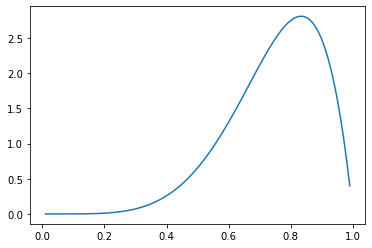

In [3]:
from scipy.stats import beta
import matplotlib.pyplot as plt

# Imagine you are looking at the distribution of car success probability.
# That's what I'm trying to represent here.
# E[p] = a/(a + b)
a =  6
b = 2
x = np.arange (0.01, 1, 0.01)
y = beta.pdf(x,a,b)
plt.plot(x,y)

In [6]:
# For a fixed number of true car and ebike trips, what happens when we vary our prior probabilities of 
# car and ebike?
p_car_list = [0.2,0.30,0.40,0.50,0.60,0.70,0.80,0.90]

n_car = 30

expected_car_list = []
car_var_list = []
for p_car in p_car_list:
    print(f"{p_car} car prior prob, {1-p_car} ebike prior prob")
    vals = trip_set_simulator_mode_counts(n_car,100-n_car, 10, NMC = 5000, 
        p_sensed_given_actual_car = {"ebike": 0.1, "car": 0.9}, 
        p_sensed_given_actual_ebike = {"ebike": 0.9, "car": 0.1},
        prior_mode_probs = {"car": p_car, "ebike":  1-p_car})
    expected_car_list.append(vals[0])
    car_var_list.append(vals[2])

ecl = np.array(expected_car_list)
cvl = np.array(car_var_list)
np.mean(ecl), np.max(np.sqrt(cvl))

0.2 car prior prob, 0.8 ebike prior prob
	sd car, ebike: 12.08,18.16
	Expected: car, ebike: (23.3, 76.7). n standard deviations: -0.55, 0.37
	Predicted: car, ebike: (31, 69). n standard deviations: 0.08, -0.06
0.3 car prior prob, 0.7 ebike prior prob
	sd car, ebike: 12.08,19.07
	Expected: car, ebike: (27.8, 72.2). n standard deviations: -0.19, 0.12
	Predicted: car, ebike: (31, 69). n standard deviations: 0.08, -0.05
0.4 car prior prob, 0.6 ebike prior prob
	sd car, ebike: 11.73,20.54
	Expected: car, ebike: (35.3, 64.7). n standard deviations: 0.45, -0.26
	Predicted: car, ebike: (36, 64). n standard deviations: 0.51, -0.29
0.5 car prior prob, 0.5 ebike prior prob
	sd car, ebike: 11.86,22.27
	Expected: car, ebike: (37.2, 62.8). n standard deviations: 0.61, -0.32
	Predicted: car, ebike: (34, 66). n standard deviations: 0.34, -0.18
0.6 car prior prob, 0.4 ebike prior prob
	sd car, ebike: 11.61,23.74
	Expected: car, ebike: (44.2, 55.8). n standard deviations: 1.23, -0.60
	Predicted: car, eb

(41.9424633684417, 12.081779163480105)

### Example of a dirichlet distribution

In [68]:
from numpy.random import default_rng
rng = default_rng()
s = rng.dirichlet((1,1,1),20).transpose()
s.shape

(3, 20)

Text(0.5, 1.0, 'Lengths of Strings')

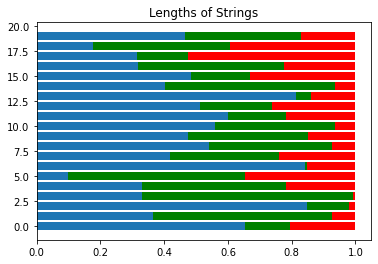

In [69]:
import matplotlib.pyplot as plt

plt.barh(range(20), s[0])

plt.barh(range(20), s[1], left=s[0], color='g')

plt.barh(range(20), s[2], left=s[0]+s[1], color='r')

plt.title("Lengths of Strings")

In [14]:
row_normalized_confusion_matrix

,ebike,car
ebike,0.6,0.4
car,0.4,0.6


In [40]:
p_sensed_given_actual_car = {"ebike": 0.4, "car": 0.6} 
p_sensed_given_actual_ebike = {"ebike": 0.6, "car": 0.4}

prior_mode_probs = {"car": 0.3, "ebike":  0.7}
row_normalized_confusion_matrix = pd.DataFrame({"ebike": p_sensed_given_actual_ebike, "car": p_sensed_given_actual_car})
likelihood_times_priors = row_normalized_confusion_matrix.multiply(pd.Series(prior_mode_probs), axis='rows')
normalizing_constants = likelihood_times_priors.sum(axis='rows')
prob_actual_given_predicted_df = likelihood_times_priors.divide(normalizing_constants, axis='columns').copy()
prob_actual_given_predicted_df.loc["car"]

ebike    0.222222
car      0.391304
Name: car, dtype: float64

### Now simulate with varied distances

In [ ]:
# Currently not complete- doesn't simulate distance.
def trip_set_simulator_with_distances(n_car, n_ebike, trip_distance, NMC, p_sensed_given_actual_car = {"ebike": 0.4, "car": 0.6}, p_sensed_given_actual_ebike = {"ebike": 0.4, "car": 0.6}):
    '''
    Simulate aggregate EC calculations for 2 modes: car and ebike.
    Start with a set of actual modes, and then assign sensed modes based on probabilities that depend on the actual mode.
        For example, if the actual mode is car and p_sensed_given_actual_car = [0.4,0.6], 
        then there is a 40% chance that we will predict ebike and 60% chance of predicting car.

    By "binomial" I mean that the set of predictions in each class is assumed to come from a binomial distribution.

    Right now the question is, which performs better on average? Expected EC or predicted EC?
    '''

    prior_mode_probs = {"car": n_car/(n_car + n_ebike), "ebike":  n_ebike/(n_car + n_ebike)}
    #prior_mode_probs = {"car": 0.5, "ebike":  0.5}
    row_normalized_confusion_matrix = pd.DataFrame({"ebike": p_sensed_given_actual_ebike, "car": p_sensed_given_actual_car})
    likelihood_times_priors = row_normalized_confusion_matrix.multiply(pd.Series(prior_mode_probs), axis='rows')
    normalizing_constants = likelihood_times_priors.sum(axis='rows')
    prob_actual_given_predicted_df = likelihood_times_priors.divide(normalizing_constants, axis='columns').copy()

    # Compute EI expected values and variances
    # [ebike value, car value]
    EI_values = np.array([0.022,1.5]) 

    car_expected_EI = cm_handling.expectation(prob_actual_given_predicted_df["car"],EI_values)
    car_E2 = cm_handling.expectation(prob_actual_given_predicted_df["car"],EI_values**2)

    ebike_expected_EI = cm_handling.expectation(prob_actual_given_predicted_df["ebike"],EI_values)
    ebike_E2 = cm_handling.expectation(prob_actual_given_predicted_df["ebike"],EI_values**2)
    V_ebike = ebike_E2 - ebike_expected_EI**2

    predicted_EC_list = np.array([])
    expected_EC_list = np.array([])
    binomial_EC_list = np.array([])

    predicted_expected_avg_list = np.array([])
   
    # Calculate expected and actual energy consumptions, assuming 10 miles.
    actual_EC_total = trip_distance*(n_car*EI_values[0] + n_ebike*EI_values[1])
    #print(f"actual EC: {actual_EC_total}")

    for j in range(0,NMC):
        # make predictions for car trips. 0 represents ebike, 1 represents car
        predictions_for_car_trips = np.random.choice([0,1],size=n_car, replace=True, p = [p_sensed_given_actual_car['ebike'], p_sensed_given_actual_car['car']])

        # make predictions for ebike trips
        predictions_for_ebike_trips = np.random.choice([0,1],size=n_ebike, replace=True, p = [p_sensed_given_actual_ebike['ebike'], p_sensed_given_actual_ebike['car']])

        n_car_predictions = sum(predictions_for_car_trips) + sum(predictions_for_ebike_trips)
        n_ebike_predictions = n_car + n_ebike - n_car_predictions

        car_distance = trip_distance*n_car_predictions
        ebike_distance = trip_distance*n_ebike_predictions

        # 0 is ebike, 1 is car
        expected_distance_in_car = np.dot(prob_actual_given_predicted_df["car"], np.array(ebike_distance,car_distance))#p_actual_given_predict_car[1]*car_distance + p_actual_given_predict_ebike[1]*ebike_distance
        expected_distance_in_ebike = np.dot(prob_actual_given_predicted_df["ebike"], np.array(ebike_distance,car_distance))

        # Compute the estimates for the current iteration.
        predicted_EC = car_distance*EI_values[0] + ebike_distance*EI_values[1]
        expected_EC = car_distance*car_expected_EI + ebike_distance*ebike_expected_EI
        binomial_EC = expected_distance_in_car*EI_values[0] + expected_distance_in_ebike*EI_values[1]
        predicted_expected_avg_EC = np.mean([predicted_EC,expected_EC])

        # Append to their respective lists.
        predicted_EC_list = np.append(predicted_EC_list, predicted_EC)
        expected_EC_list = np.append(expected_EC_list, expected_EC)
        binomial_EC_list = np.append(binomial_EC_list, binomial_EC)
        predicted_expected_avg_list = np.append(predicted_expected_avg_list, predicted_expected_avg_EC)

    prediction_errors = predicted_EC_list - actual_EC_total
    expected_EC_errors = expected_EC_list - actual_EC_total
    binomial_EC_errors = binomial_EC_list - actual_EC_total
    predicted_expected_avg_errors = predicted_expected_avg_list - actual_EC_total

    prediction_var, expected_var, binomial_var, predicted_expected_var = np.var(predicted_EC_list), np.var(expected_EC_list), np.var(binomial_EC_list), np.var(predicted_expected_avg_list)

    print(f"\tMean error for predicted: {np.mean(prediction_errors):.1f}. Error quantiles (25,75): {np.quantile(prediction_errors, [0.25,0.75])}. var of predicted: {prediction_var:.1f}")
    print(f"\tMean error for expected: {np.mean(expected_EC_errors):.1f}. Error quantiles (25,75): {np.quantile(expected_EC_errors, [0.25,0.75])}. var of expected: {expected_var:.1f}")
    print(f"\tMean error for binomial: {np.mean(binomial_EC_errors):.1f}. Error quantiles (25,75): {np.quantile(binomial_EC_errors, [0.25,0.75])}. var of binomial: {binomial_var:.1f}")
    #print(f"\tMean error for average: {np.mean(predicted_expected_avg_errors):.1f}. Error quantiles (25,75): {np.quantile(predicted_expected_avg_errors, [0.25,0.75])}. var of combined estimate: {predicted_expected_var:.1f}")

# try it with predicted and try it with modeshare.
car_number_list = [30,40,50,60,70,80,90]


# which does better on average in each situation?

for n_car in car_number_list:
    print(f"{n_car} car trips, {100 - n_car} ebike trips")
    trip_set_simulator(n_car,100-n_car, 10, NMC = 5000)

In [ ]:
n_car_predictions = 80
n_ebike_predictions = 20
observed_predictions = ['car']*n_car_predictions + ['ebike']*n_ebike_predictions

# make predictions for car trips. 0 represents ebike, 1 represents car
predictions_for_car_trips = np.random.choice([0,1],size=n_car, replace=True, p = [0.4,0.6])

# make predictions for ebike trips
predictions_for_ebike_trips = np.random.choice([0,1],size=n_ebike, replace=True, p = [0.6,0.4])

In [ ]:
# what is the chance of predicting car car car ebike given actual modes of car, ebike, ebike, ebike?
# we'll say order doesn't matter, since multiple trip orderings can yield the same energy consumption
# I am also assuming P(actual|predicted) = P(predicted| actual)
3*(0.6**2 * 0.4**2) + 0.4**4  # almost 20%

# what is the chance of being over 2 standard deviations away across all possible trip prediction sequences?